<a href="https://colab.research.google.com/github/james130625/notebook/blob/main/14_S%26P500%EC%B5%9C%EC%A2%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,074 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 121913 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr

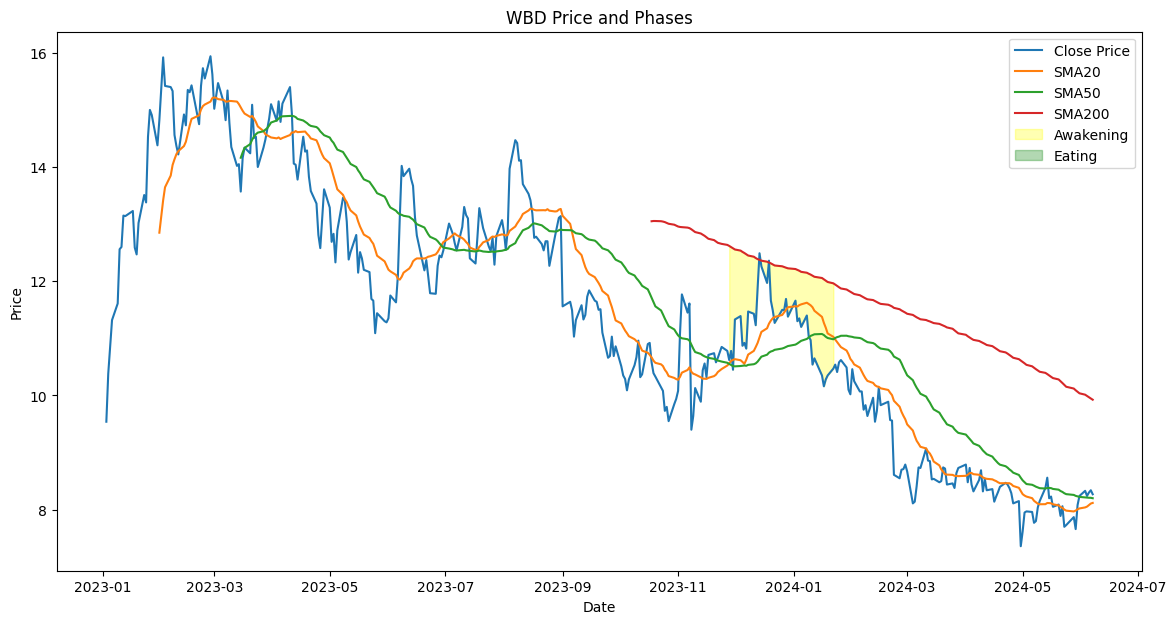

Index(['Symbol', 'Current Price', 'Recent Close', 'Trend', 'Buy Range',
       'First Buy', 'Second Buy', 'Third Buy', 'Take Profit', 'Stop Loss',
       'Avg Volume', 'Volatility', 'Phase'],
      dtype='object')
조건에 맞는 상위 10개 종목 목록:
  Symbol  Current Price  Recent Close    Trend    Buy Range  First Buy  \
0    WBD           8.27          8.27  Uptrend  8.10 - 8.44     8.1046   

   Second Buy  Third Buy  Take Profit  Stop Loss    Avg Volume  Volatility  \
0        8.27     8.4354        9.097     7.8565  2.311970e+07    2.222927   

      Phase  
0  Sleeping  


,Symbol,Current Price,Recent Close,Trend,Buy Range,First Buy,Second Buy,Third Buy,Take Profit,Stop Loss,Avg Volume,Volatility,Phase
0,WBD,8.27,8.27,Uptrend,8.10 - 8.44,8.1046,8.27,8.4354,9.097,7.8565,2.311970e+07,2.222927,Sleeping


In [1]:
# 필요한 패키지 설치
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm -rf ~/.cache/matplotlib

# FinanceDataReader 설치
!pip install finance-datareader

# matplotlib, pandas 임포트 및 주피터 출력 설정, 한글 폰트 지정
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
from datetime import datetime

plt.rcParams['font.family'] = 'NanumBarunGothic'  # 한글 출력을 위한 폰트 설정

# S&P500 상장 목록 가져오기
sp500_list = fdr.StockListing('S&P500')

# 데이터프레임의 열 이름 확인
print(sp500_list.columns)

# 열 이름 확인 후 'Symbol' 열 사용
symbol_column_name = 'Symbol'
close_column_name = 'Close'

# 필터링 조건
price_lower = 5
price_upper = 10

# 필터링된 데이터프레임 저장용 리스트
filtered_stocks_data = []

# 오늘 날짜 구하기
today = datetime.today().strftime('%Y-%m-%d')

# 각 종목의 데이터를 가져와서 조건에 맞는지 확인 및 상태 식별
for symbol in sp500_list[symbol_column_name]:
    try:
        # 종목 데이터 불러오기 (2023-01-02부터 오늘까지)
        data = fdr.DataReader(symbol, '2023-01-02', today)

        # 종가가 5-10 달러 사이에 있는지 확인
        if data[close_column_name].iloc[-1] < price_lower or data[close_column_name].iloc[-1] > price_upper:
            continue

        # 이동 평균 계산
        data['SMA20'] = data[close_column_name].rolling(window=20).mean()
        data['SMA50'] = data[close_column_name].rolling(window=50).mean()
        data['SMA200'] = data[close_column_name].rolling(window=200).mean()

        # 거래량 평균 계산
        avg_volume = data['Volume'].mean()

        # 변동폭 계산 (종가의 표준편차)
        volatility = data[close_column_name].std()

        # MACD 및 시그널 계산
        exp1 = data[close_column_name].ewm(span=12, adjust=False).mean()
        exp2 = data[close_column_name].ewm(span=26, adjust=False).mean()
        macd = exp1 - exp2
        signal = macd.ewm(span=9, adjust=False).mean()

        # 가장 최근 종가
        recent_close = data[close_column_name].iloc[-1]

        # 추세 계산
        trend = 'Uptrend' if macd.iloc[-1] > signal.iloc[-1] else 'Downtrend'

        # 매수가 범위 계산 (±2%)
        buy_range_low = recent_close * 0.98
        buy_range_high = recent_close * 1.02

        # 1차, 2차, 3차 매수가
        first_buy = buy_range_low
        second_buy = (buy_range_low + buy_range_high) / 2
        third_buy = buy_range_high

        # 익절가 (최근 종가의 +10%)
        take_profit = recent_close * 1.10

        # 손절가 (최근 종가의 -5%)
        stop_loss = recent_close * 0.95

        # 상태 식별
        data['Phase'] = 'Sleeping'
        conditions = [
            (data['SMA20'] > data['SMA50']) & (data['SMA50'] > data['SMA200']),
            (data['SMA20'] > data['SMA50']) & (data['SMA50'] < data['SMA200']),
        ]
        choices = ['Eating', 'Awakening']
        data['Phase'] = np.select(conditions, choices, default='Sleeping')

        # 조건 필터링
        if macd.iloc[-1] > signal.iloc[-1]:  # MACD 매수 시그널
            filtered_stocks_data.append({
                'Symbol': symbol,
                'Current Price': recent_close,
                'Recent Close': recent_close,
                'Trend': trend,
                'Buy Range': f"{buy_range_low:.2f} - {buy_range_high:.2f}",
                'First Buy': first_buy,
                'Second Buy': second_buy,
                'Third Buy': third_buy,
                'Take Profit': take_profit,
                'Stop Loss': stop_loss,
                'Avg Volume': avg_volume,
                'Volatility': volatility,
                'Phase': data['Phase'].iloc[-1]
            })

            # 상태별 차트 그리기
            plt.figure(figsize=(14, 7))
            plt.plot(data.index, data[close_column_name], label='Close Price')
            plt.plot(data.index, data['SMA20'], label='SMA20')
            plt.plot(data.index, data['SMA50'], label='SMA50')
            plt.plot(data.index, data['SMA200'], label='SMA200')

            # 상태별로 색상 채우기
            awakening_phase = data[data['Phase'] == 'Awakening']
            eating_phase = data[data['Phase'] == 'Eating']

            plt.fill_between(awakening_phase.index, awakening_phase['SMA200'], awakening_phase[close_column_name], color='yellow', alpha=0.3, label='Awakening')
            plt.fill_between(eating_phase.index, eating_phase['SMA200'], eating_phase[close_column_name], color='green', alpha=0.3, label='Eating')

            plt.title(f'{symbol} Price and Phases')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.legend()
            plt.show()

    except Exception as e:
        # 데이터 불러오기에 실패하면 무시
        print(f"Failed to process {symbol}: {e}")
        continue

# 필터링된 종목 데이터프레임 생성 및 정렬
filtered_stocks_df = pd.DataFrame(filtered_stocks_data)

# 데이터프레임에 'Avg Volume' 및 'Volatility' 열이 포함되어 있는지 확인
print(filtered_stocks_df.columns)

# 거래량이 많고 변동폭이 낮은 순으로 정렬
filtered_stocks_df = filtered_stocks_df.sort_values(by=['Avg Volume', 'Volatility'], ascending=[False, True])

# 상위 10개 종목 선정
top_10_stocks_df = filtered_stocks_df.head(10)

# 결과 출력
print("조건에 맞는 상위 10개 종목 목록:")
print(top_10_stocks_df)

# 필터링된 종목 리스트 데이터프레임 출력 함수
def display_dataframe_to_user(name: str, dataframe: pd.DataFrame) -> None:
    from IPython.display import display, HTML
    display(HTML(f"<h2>{name}</h2>"))
    display(dataframe)

display_dataframe_to_user(name="조건에 맞는 상위 10개 S&P500 종목 목록", dataframe=top_10_stocks_df)
